<a href="https://colab.research.google.com/github/haedongmu/AIFFEL_quest_cr/blob/main/Exploration/Ex02/ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1. 데이터 수집하기

In [3]:
from importlib.metadata import version
import nltk
import tensorflow
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
from tqdm import tqdm  # tqdm 추가
from collections import Counter  # Counter import 추가
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!pip install summa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54387 sha256=e4561fd7c2a8b7b7e320cd2db7b39d652912fc66c8eff3b943f3d006d1db68e6
  Stored in directory: /root/.cache/pip/wheels/10/2d/7a/abce87c4ea233f8dcca0d99b740ac0257eced1f99a124a0e1f
Successfully built summa


In [9]:
# NLTK stopwords 다운로드 (추가)
try:
    nltk.download('stopwords')
    print("NLTK stopwords 다운로드 완료.")
except Exception as e:
    print(f"NLTK stopwords 다운로드 실패: {e}")
    print("스크립트가 불용어 제거 없이 진행될 수 있습니다.")

# 버전 확인
print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

NLTK stopwords 다운로드 완료.
3.9.1
2.18.0
2.2.2
1.2.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# 파일 경로
file_path = "news_summary_more.csv"
preprocessed_text_file = "clean_text.csv"  # Preprocessed text 저장 파일
preprocessed_headlines_file = "clean_headlines.csv"  # Preprocessed headlines 저장 파일
model_file = "news_summary_model.h5"  # 모델 저장 파일 경로


# 파일이 없으면 다운로드
if not os.path.exists(file_path):
    print("CSV 파일이 존재하지 않습니다. 다운로드를 진행합니다.")
    urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename=file_path)
else:
    print("CSV 파일이 이미 존재합니다.")

data = pd.read_csv(file_path, nrows=100000)
print('전체 샘플수 :', (len(data)))

CSV 파일이 이미 존재합니다.
전체 샘플수 : 98401


Step 2. 데이터 전처리하기 (추상적 요약)

In [12]:
# 중복치 확인
print('전체 headline 데이터', len(data['headlines']))
print('유니크한 headline 데이터: ', (data['headlines'].nunique()))
print('전체 text 데이터', len(data['text']))
print('유니크한 text데이터', data['text'].nunique())

data.drop_duplicates(subset=['text'], inplace=True)

# 정규화 사전
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "I am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what_re": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll_ve": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd_ve": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}
# 불용어 리스트 확인
print('불용어 개수 : ', len(stopwords.words('english')))
print(stopwords.words('english'))

전체 headline 데이터 98401
유니크한 headline 데이터:  98280
전체 text 데이터 98401
유니크한 text데이터 98360
불용어 개수 :  198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', '

In [13]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text  # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '',
                      sentence)  # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"', '', sentence)  # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])  # 약어 정규화
    sentence = re.sub(r"'s\b", "", sentence)  # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)  # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


# 샘플 문장을 확인

temp_text = 'Everything I bought was great, infact I ordered iiiiit twice and the third ordered 123 was<br />for my mother and father. '
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

clean_text = []
clean_headlines = []

text:  everything bought great infact ordered iiiiit twice third ordered wasfor mother father
summary: great way to start the day


In [14]:
# Preprocessed 파일 확인 및 로드 또는 전처리 실행
if os.path.exists(preprocessed_text_file) and os.path.exists(preprocessed_headlines_file):
    print("저장된 전처리 파일들을 로드합니다...")
    clean_text = pd.read_csv(preprocessed_text_file)['text'].tolist()
    clean_headlines = pd.read_csv(preprocessed_headlines_file)['headlines'].tolist()
    print("전처리 파일 로드 완료.")
else:
    print("전처리 파일이 없습니다. 전처리를 시작합니다...")
    for s in tqdm(data['text'], desc="Preprocessing text"):
        clean_text.append(preprocess_sentence(s))

    for s in tqdm(data['headlines'], desc="Preprocessing headlines"):
        clean_headlines.append(preprocess_sentence(s, False))

    print('Text 전처리 후 결과 (샘플 5개): ', clean_text[:5])
    print('Headlines 전처리 후 결과 (샘플 5개): ', clean_headlines[:5])

    # DataFrame으로 만들고 CSV 파일로 저장
    pd.DataFrame({'text': clean_text}).to_csv(preprocessed_text_file, index=False)
    pd.DataFrame({'headlines': clean_headlines}).to_csv(preprocessed_headlines_file, index=False)
    print(f"전처리 완료 및 결과 저장: {preprocessed_text_file}, {preprocessed_headlines_file}")


data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('', np.nan, inplace=True)

data.isnull().sum()

import matplotlib.pyplot as plt

text_len = [len(x.split()) for x in data['text']]
headlines_len = [len(x.split()) for x in data['headlines']]

print('텍스트 길이 최대: ', np.max(text_len))
print('텍스트 길이 최소: ', np.min(text_len))
print('텍스트 길이 평균: ', np.mean(text_len))
print('헤드라인 길이 최대: ', np.max(headlines_len))
print('헤드라인 길이 최소: ', np.min(headlines_len))
print('헤드라인 길이 평균: ', np.mean(headlines_len))

전처리 파일이 없습니다. 전처리를 시작합니다...


Preprocessing headlines: 100%|██████████| 98360/98360 [00:17<00:00, 5706.59it/s]


Text 전처리 후 결과 (샘플 5개):  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers optio

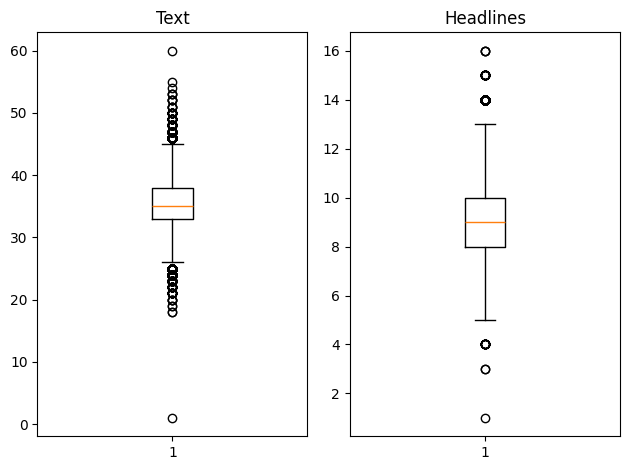

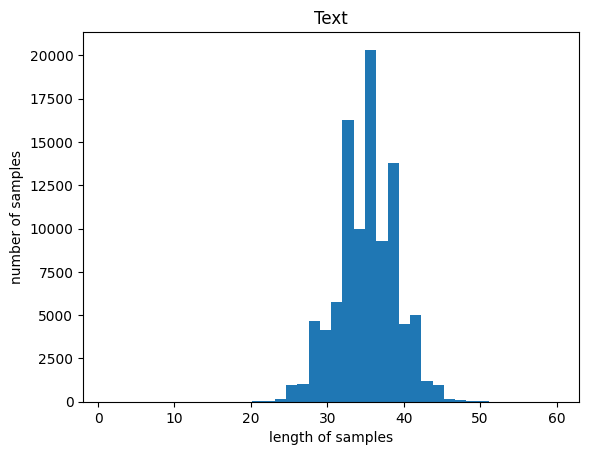

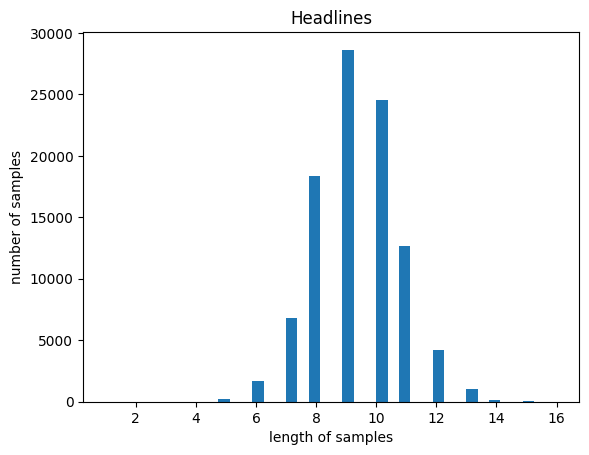

In [15]:
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
# 텍스트, 헤드라인 최대 길이 설정
max_text_len = 60
max_headline_len = 16


# 최대 길이를 기준으로 나눴을때 최대 길이보다 짧은 데이터의 비율을 출력해주는 함수 정의
def below_threshold_len(max_len, list):
    count = 0
    for s in list:
        if len(s.split()) <= max_len:
            count += 1

    print(f'길이가 {max_len}보다 짧은 데이터의 비율 : {count / len(list)}')


# 비율 확인
below_threshold_len(max_text_len, data['text'])
below_threshold_len(max_headline_len, data['headlines'])


data['decoder_input'] = data['headlines'].apply(lambda x : 'starttoken ' + x)
data['decoder_output'] = data['headlines'].apply(lambda x : x + ' endtoken')

data.head()

encoder_input = np.array(data['text'])

decoder_input = np.array(data['decoder_input'])
decoder_output = np.array(data['decoder_output'])

# 데이터 섞어주기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_output = decoder_output[indices]

# 샘플 추출
encoder_input[:5]

val_size = int(encoder_input.shape[0] * 0.2)

encoder_input_train = encoder_input[:-val_size]
decoder_input_train = decoder_input[:-val_size]
decoder_output_train = decoder_output[:-val_size]

encoder_input_test = encoder_input[-val_size:]
decoder_input_test = decoder_input[-val_size:]
decoder_output_test = decoder_output[-val_size:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

# 토크나이저 설정
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

# 단어 빈도수 체크
threshold = 4
total_cnt = len(src_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if value < threshold:
        rare_cnt += 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s' % (total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

src_vocab = 30847
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

# 정수 인코딩
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 샘플 출력하여 확인
print(encoder_input_train[:3])

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)


threshold = 4
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

tar_vocab = 13676
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_output_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_output_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_output_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

encoder_input_train = pad_sequences(encoder_input_train, maxlen=max_text_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=max_text_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_headline_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=max_headline_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=max_headline_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=max_headline_len, padding='post')


길이가 60보다 짧은 데이터의 비율 : 1.0
길이가 16보다 짧은 데이터의 비율 : 1.0
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672
단어 집합(vocabulary)의 크기 : 69691
등장 빈도가 3번 이하인 희귀 단어의 수: 40028
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 29663
단어 집합에서 희귀 단어의 비율: 57.436397813203996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.1850936975651014
[[36, 58, 45, 49, 116, 47, 19485, 24025, 67, 1253, 3451, 2952, 19, 2093, 230, 1191, 1932, 1349, 15987, 2757, 49, 47, 12236, 22188, 230, 7353, 1356, 4, 36, 47, 8, 2093, 1191, 1920, 43, 36, 1774, 937, 1], [79, 29664, 6492, 1350, 2014, 188, 4471, 2243, 101, 194, 516, 367, 893, 85, 463, 74, 235, 9151, 242, 1273, 2237, 34, 3198, 13801, 29664, 3339, 1624, 218, 317, 12932, 15988, 4471, 742, 29664, 115, 29, 3], [95, 2, 612, 219, 75, 216, 434, 750, 28, 4033, 2758, 1775, 1, 377, 200, 2477, 100, 650, 422, 75, 22, 2, 14265, 902, 553, 908, 1775, 1, 434, 750, 22, 4591, 1265, 2, 6974, 498, 1910]]
단어 집합(vocabulary)의 크기 : 30110
등장 빈도가 3번 이하인 희귀 단어의 수: 16984
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 131

Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [17]:
# --- 모델 정의 --- #
embedding_dim = 256
hidden_size = 128

# 인코더
encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.5)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# 디코더
decoder_inputs = Input(shape=(None, ))
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
attn_layer = AdditiveAttention(name='attention_layer')
attn_out = attn_layer([decoder_outputs, encoder_outputs])
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

In [18]:
# 모델 파일 존재 여부 확인 및 모델 로드 또는 새로 생성
if os.path.exists(model_file):
    print("모델 파일이 존재합니다. 모델을 로드합니다.")
    model = tensorflow.keras.models.load_model(model_file)
    print("모델 훈련을 건너뛰었습니다.")  # 모델 로드 시 훈련 건너뜀 메시지 추가
else:
    print("모델 파일이 없습니다. 새로운 모델을 훈련합니다.")
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
    es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
    print("모델 훈련 시작...")  # 훈련 시작 메시지 추가
    history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
                        validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                        batch_size=256, callbacks=[es], epochs=50)
    print("모델 훈련 종료.") # 훈련 종료 메시지 추가
    model.save(model_file) # 훈련 후 모델 저장
    print(f"훈련된 모델 저장: {model_file}") # 모델 저장 완료 메시지 추가

model.summary()

모델 파일이 없습니다. 새로운 모델을 훈련합니다.
모델 훈련 시작...
Epoch 1/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 84s 247ms/step - loss: 5.4286 - val_loss: 4.3831
Epoch 2/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 79s 252ms/step - loss: 4.4131 - val_loss: 4.3251
Epoch 3/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 80s 260ms/step - loss: 4.3493 - val_loss: 4.2584
Epoch 4/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 79s 252ms/step - loss: 4.2898 - val_loss: 4.2200
Epoch 5/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 77s 251ms/step - loss: 4.2397 - val_loss: 4.1649
Epoch 6/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 85s 261ms/step - loss: 4.1808 - val_loss: 4.0923
Epoch 7/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 79s 252ms/step - loss: 4.0956 - val_loss: 4.0092
Epoch 8/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 80s 261ms/step - loss: 4.0135 - val_loss: 3.9431
Epoch 9/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 80s 253ms/step - loss: 3.9427 - val_loss: 3.9039
Epoch 10/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 80s 260ms/step - loss: 3.8891 - val_loss: 3.8440
Epoch 11/50
308/308 ━━━━━━━━━━━━━━━━━━━━ 80s 253ms/step - loss: 3.832

모델 훈련 종료.
훈련된 모델 저장: news_summary_model.h5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 60)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 60, 256)        │      7,896,832 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 60, 128),      │        197,120 │ embedding[0][0]        │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 60, 128),      │        131,584 │ lstm[0][0]             │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 256)      │      3,501,056 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 60, 128),      │        131,584 │ lstm_1[0][0]           │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 128),    │        197,120 │ embedding_1[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm_2[0][1],          │
│                           │ 128)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 128)      │            128 │ lstm_3[0][0],          │
│ (AdditiveAttention)       │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 256)      │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 13676)    │      3,514,732 │ concat_layer[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 31,140,314 (118.79 MB)

 Trainable params: 15,570,156 (59.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,570,158 (59.40 MB)

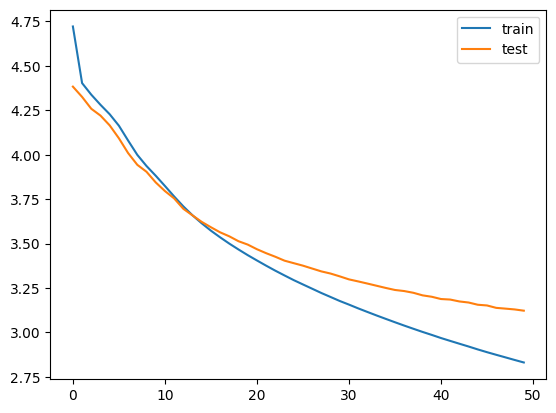

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [20]:
src_index_to_word = src_tokenizer.index_word  # 원문 단어 집합에서 정수 -> 단어
tar_word_to_index = tar_tokenizer.word_index  # 요약 단어 집합에서 단어 -> 정수
tar_index_to_word = tar_tokenizer.index_word  # 요약 단어 집합에서 정수 -> 단어

# 인코더 모델 별도 저장
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 디코더 모델 별도 저장
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))
decoder_hidden_state_input_c = Input(shape=(max_text_len, hidden_size)) # 누락된 Input layer 추가 (decoder_input_state_c -> decoder_hidden_state_input_c로 변경)
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2,
                                                    initial_state=[decoder_state_input_h, decoder_state_input_c])
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input_c]) # decoder_hidden_state_input_c로 변경
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input_c, decoder_state_input_h, decoder_state_input_c], # decoder_hidden_state_input_c로 변경
    [decoder_outputs2] + [state_h2, state_c2])


def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index['starttoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) # e_out 유지, decoder_hidden_state_input_c 불필요
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token != 'endtoken'):
            decoded_sentence += ' ' + sampled_token

        # <EOS>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'endtoken' or len(decoded_sentence.split()) >= (max_headline_len - 1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['starttoken']) and i!=tar_word_to_index['endtoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp


from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Sentence-BERT 모델 로드 (다국어 모델 또는 영어 모델 선택 가능)
# model = SentenceTransformer('xlm-r-bert-base-nli-stsb-mean-tokens') # 다국어 모델 (multilingual)
model = SentenceTransformer('bert-base-nli-mean-tokens') # 영어 모델 (english)

semantic_scores = []

for i in range(50, 60):
    actual_summary = seq2summary(decoder_input_test[i])
    predicted_summary = decode_sequence(encoder_input_test[i].reshape(1, max_text_len))

    # Sentence-BERT를 사용하여 문장 임베딩 벡터 생성
    embeddings = model.encode([actual_summary, predicted_summary])

    # 코사인 유사도 계산
    similarity = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    semantic_scores.append(similarity)

    print(f"**[샘플 {i-49 + 1}/10]**") # 샘플 번호 1부터 시작
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", actual_summary)
    print("예측 요약 :", predicted_summary)
    print("Semantic 유사도 (Cosine Similarity):", similarity)
    print("\n")

average_semantic_similarity = sum(semantic_scores) / len(semantic_scores)
print(f"**평균 Semantic 유사도 (샘플 10개): {average_semantic_similarity:.4f}**")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.77k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
**[샘플 2/10]**
원문 : least seven people died due swine flu past days punjab ludhiana district civil surgeon pal singh sidhu said ludhiana seen suspected cases swine flu confirmed added cases registered three people died said 
실제 요약 : swine flu claims seven lives in days in ludhiana 
예측 요약 :  dead in mumbai after heavy rains in mumbai
Semantic 유사도 (Cosine Similarity): 0.52817225


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━

Step 5. Summa을 이용해서 추출적 요약해보기((추상적 요약과 비교)

In [22]:
pip install summa

In [25]:
from summa import summarizer

In [26]:
semantic_scores_abstractive = [] # 추상적 요약 semantic score 저장 리스트
semantic_scores_extractive = [] # 추출적 요약 semantic score 저장 리스트

print("\n**[추상적 요약 결과]**") # 섹션 구분을 위한 제목 추가

for i in range(30, 40):
    original_text = data['text'].iloc[indices[50+i-50]] # 원본 텍스트 (Summa용)
    actual_summary = seq2summary(decoder_input_test[i])
    predicted_summary_abstractive = decode_sequence(encoder_input_test[i].reshape(1, max_text_len))

    # Sentence-BERT를 사용하여 문장 임베딩 벡터 생성 (추상적 요약)
    embeddings_abstractive = model.encode([actual_summary, predicted_summary_abstractive])

    # 코사인 유사도 계산 (추상적 요약)
    similarity_abstractive = cosine_similarity([embeddings_abstractive[0]], [embeddings_abstractive[1]])[0][0]
    semantic_scores_abstractive.append(similarity_abstractive)


    # Summa를 이용한 추출적 요약
    predicted_summary_extractive = summarizer.summarize(original_text, ratio=0.4) # ratio 값 조정 (원문 대비 요약 비율)
    if not predicted_summary_extractive: # Summa 요약 결과가 없을 경우 첫 문장으로 대체 (선택 사항)
        predicted_summary_extractive = original_text.split('.')[:2] # 첫 두 문장으로 대체
        predicted_summary_extractive = '.'.join(predicted_summary_extractive) + '.'


    # Sentence-BERT를 사용하여 문장 임베딩 벡터 생성 (추출적 요약)
    embeddings_extractive = model.encode([actual_summary, predicted_summary_extractive])

    # 코사인 유사도 계산 (추출적 요약)
    similarity_extractive = cosine_similarity([embeddings_extractive[0]], [embeddings_extractive[1]])[0][0]
    semantic_scores_extractive.append(similarity_extractive)


    print(f"**[샘플 {i-49 + 1}/10]**") # 샘플 번호 1부터 시작
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", actual_summary)
    print("- 추상적 요약 :", predicted_summary_abstractive)
    print("  Semantic 유사도 (추상적):", similarity_abstractive)
    print("- 추출적 요약 (Summa):", predicted_summary_extractive)
    print("  Semantic 유사도 (추출적):", similarity_extractive)
    print("\n")

average_semantic_similarity_abstractive = sum(semantic_scores_abstractive) / len(semantic_scores_abstractive)
average_semantic_similarity_extractive = sum(semantic_scores_extractive) / len(semantic_scores_extractive)

print(f"**[추상적 요약] 평균 Semantic 유사도 (샘플 10개): {average_semantic_similarity_abstractive:.4f}**")
print(f"**[추출적 요약 - Summa] 평균 Semantic 유사도 (샘플 10개): {average_semantic_similarity_extractive:.4f}**")


**[추상적 요약 결과]**
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
**[샘플 -18/10]**
원문 : china denied reports claiming country wants act mediator india pakistan help resolve kashmir issue adding issue settled bilaterally state run publication global times stated earlier china ready act mediator vested interest owing investments pakistan occupied kashmir 
실제 요약 : will not mediate between india pakistan over kashmir china 
- 추상적 요약 :  china rejects india to india india over its brexit
  Semantic 유사도 (추상적): 0.8155675
- 추출적 요약 (Summa): combined market valuation six valued indian companies declined crore last week information tech

**회고**

*   LMS 노드를 따라서 열심히 작업하였으나, 요약결과는 한 단어만 반복적으로 나왔습니다.
*  chat GPT 에게 질의하여 이런 저런 시도를 해보았으나 효과가 없었습니다.
*  마지막 최후의 수단으로 딥 리서치를 사용하였습니다. 딥 리서치 스스로 코딩을 하지는 않았고, 인터넷상에서 가장 오류가 없고 잘 정리된 페이지를 1개 찾아 주었습니다.
*  실행과정에서는 다소나마 역시 오류가 있었습니다. 이번에는 제미나이 Thinking Experimental 에게 질의를 하여 오류를 수정하였습니다.
*  최종결과는 그래도 예측요약과 다소 비슷한 실제 요약 결과를 도출할 수 있었습니다. 정확도는 의미론적 유사도를 측정을 통해 계산하였습니다.
*  플러터앱은 구현할 시간이 부족하여 통과합니다.

